# Import Librairies

In [151]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets 
from ipywidgets import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier

In [152]:
from pyspark.sql import SparkSession
from pyspark import SparkConf
spark = SparkSession \
.builder \
.appName(" churn prediction") \
.config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5") \
.getOrCreate()


In [153]:
%%html

<style>
div.output_area pre {
    white-space: pre;
}
</style>

# Loading Data

In [154]:

pdf = pd.read_excel('mobile-churn-data.xlsx', engine='openpyxl')


In [155]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66469 entries, 0 to 66468
Data columns (total 66 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   year                                        66469 non-null  int64  
 1   month                                       66469 non-null  int64  
 2   user_account_id                             66469 non-null  int64  
 3   user_lifetime                               66469 non-null  int64  
 4   user_intake                                 66469 non-null  int64  
 5   user_no_outgoing_activity_in_days           66469 non-null  int64  
 6   user_account_balance_last                   66469 non-null  float64
 7   user_spendings                              66469 non-null  float64
 8   user_has_outgoing_calls                     66469 non-null  int64  
 9   user_has_outgoing_sms                       66469 non-null  int64  
 10  user_use_g

In [156]:
#a=pdf.groupby(['churn']).count()
#a

# DataViz

### Distribution des classes de churn 

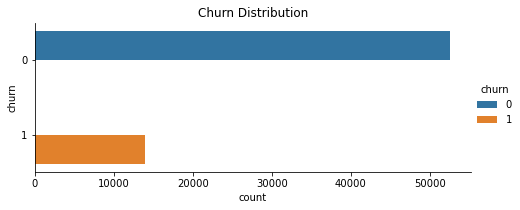

20.922535317215544 % churners


In [157]:

ax = sns.catplot(y="churn", kind="count", data=pdf, hue= 'churn', palette = 'tab10', height=2.6, aspect=2.5, orient='h')
plt.title('Churn Distribution')
plt.show()

#pourcentage des churners 
prop_churn = sum(pdf['churn'] == 1) / len(pdf['churn'])*100
print(str(prop_churn) + ' % churners')

In [158]:
# D'après ce graphe on constate que la majorité des clients ne sont pas désabonnés (environ 80%)
#D'autre par notre dataset présente un problème de déséquilibre qui peut impacter négativement la performance des modèles
#de classification que nous allons créer

In [159]:
b = pdf.nunique()[pdf.nunique() < 5].keys().to_list()

In [169]:
dd = widgets.Dropdown(options= b, value=b[0], description= 'Column')
def draw_countplot(column):
    p = sns.countplot(data=pdf, x= column, hue='churn', palette='plasma')
    if len(pdf[column].unique()) > 4 :
        p.tick_params(axis='x', rotation =90)
    plt.title('Distribution de ' + str(column))
    return plt.show()
              
interact(draw_countplot, column=dd)


interactive(children=(Dropdown(description='Column', options=('year', 'month', 'user_intake', 'user_has_outgoi…

<function __main__.draw_countplot(column)>

# Data Processing

In [170]:
df_1= pdf[pdf['churn']==1]
df_1_final = df_1[:13907]
df_1_final

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
3,2013,6,27,1013,0,11,5.62,0.00,1,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
11,2013,6,69,769,0,90,30.01,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
12,2013,6,73,732,0,28,2.42,3.68,1,1,...,15.48,0.0,1.0,0.0,26,0,1,0,0.0,1
20,2013,6,104,15885,0,1276,0.00,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
50,2013,6,279,15885,0,8,0.00,0.00,1,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66461,2013,8,1196934,15947,0,1,0.00,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
66462,2013,8,1196935,15947,0,1,0.00,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
66463,2013,8,1196936,15947,0,1,0.00,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1
66464,2013,8,1196937,15947,0,1,0.00,0.00,0,0,...,0.00,0.0,0.0,0.0,0,0,0,0,0.0,1


In [171]:
df_0= pdf[pdf['churn']==0]
df_0_final = df_0[:13907]
df_0_final

,year,month,user_account_id,user_lifetime,user_intake,user_no_outgoing_activity_in_days,user_account_balance_last,user_spendings,user_has_outgoing_calls,user_has_outgoing_sms,...,last_100_calls_outgoing_duration,last_100_calls_outgoing_to_onnet_duration,last_100_calls_outgoing_to_offnet_duration,last_100_calls_outgoing_to_abroad_duration,last_100_sms_outgoing_count,last_100_sms_outgoing_to_onnet_count,last_100_sms_outgoing_to_offnet_count,last_100_sms_outgoing_to_abroad_count,last_100_gprs_usage,churn
0,2013,6,13,1000,0,1,0.05,0.00,1,1,...,75.27,0.00,63.43,0.00,210,1,84,0,0.0,0
1,2013,6,14,1000,0,25,28.31,3.45,1,0,...,13.38,11.18,2.00,11.18,0,0,0,0,0.0,0
2,2013,6,18,1005,0,8,15.62,1.97,1,0,...,30.00,0.00,0.00,10.45,0,0,0,0,0.0,0
4,2013,6,32,1032,0,2,5.86,0.15,1,0,...,2.58,0.00,1.00,0.00,0,0,0,0,0.0,0
5,2013,6,35,1039,0,1,12.51,12.96,1,1,...,356.65,0.00,215.83,0.00,4,1,1,0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15283,2013,6,217538,1805,0,2,5.99,1.47,1,1,...,0.45,0.00,0.00,0.45,28,0,2,26,0.0,0
15284,2013,6,217589,1640,0,3,6.64,1.62,0,1,...,1.57,0.00,1.00,0.00,111,0,101,7,0.0,0
15285,2013,6,217593,1719,0,5,1.05,0.25,1,0,...,8.32,0.00,3.00,0.00,0,0,0,0,0.0,0
15286,2013,6,217594,1847,0,1,18.29,5.71,1,1,...,48.45,1.50,37.23,8.28,156,0,66,39,0.0,0


In [172]:
df_after_concat =pd.concat([df_0_final, df_1_final], ignore_index=True)

In [173]:
df_after_concat.to_csv("/home/jovyan/work/balanced_data", header=True)

In [174]:

df = spark.read.csv('/home/jovyan/work/balanced_data', header = True)


In [175]:
df.show(5)

+---+----+-----+---------------+-------------+-----------+---------------------------------+-------------------------+--------------+-----------------------+---------------------+-------------+----------------+---------------------+-------------+-----------+--------------------+------------------------+-----------------------+----------------------------+---------------------------+----------------------------+-----------------------------+---------------------------------+--------------------------------+-------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------+----------------------+--------------------------+--------------------------+---------------------------+-------------------------------+-----------------

In [176]:
'''from IPython.display import display, HTML
display(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>")) '''


'from IPython.display import display, HTML\ndisplay(HTML("<style>div.jp-OutputArea-output pre {white-space: pre;}</style>")) '

In [177]:
# Statistiques Descriptives
dfSummary = df.summary().show(truncate=False)


+-------+---------------+------+------------------+------------------+-----------------+--------------------+---------------------------------+-------------------------+------------------+-----------------------+---------------------+--------------------+-------------------+---------------------+------------------+------------------+--------------------+------------------------+-----------------------+----------------------------+---------------------------+----------------------------+-----------------------------+---------------------------------+--------------------------------+-------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------+----------------------+--------------------------+--------------------------+

In [178]:
df.groupBy('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|13907|
|    1|13907|
+-----+-----+



In [179]:
# ==> dataset équilibrée

In [180]:
# Vérification de la présence des valeurs manquantes / nulles
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()


+---+----+-----+---------------+-------------+-----------+---------------------------------+-------------------------+--------------+-----------------------+---------------------+-------------+----------------+---------------------+-------------+-----------+--------------------+------------------------+-----------------------+----------------------------+---------------------------+----------------------------+-----------------------------+---------------------------------+--------------------------------+-------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------+----------------------+--------------------------+--------------------------+---------------------------+-------------------------------+-----------------

In [181]:
#Suppression des variables non nécessaires
unuseful_columns= ['_c0','year','user_account_id']
cleaned_df = df.drop(*unuseful_columns)
cleaned_df.show(2)

+-----+-------------+-----------+---------------------------------+-------------------------+--------------+-----------------------+---------------------+-------------+----------------+---------------------+-------------+-----------+--------------------+------------------------+-----------------------+----------------------------+---------------------------+----------------------------+-----------------------------+---------------------------------+--------------------------------+-------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------+----------------------+--------------------------+--------------------------+---------------------------+-------------------------------+-----------------------------------+------

In [182]:
cleaned_df.groupby('churn').count().show()

+-----+-----+
|churn|count|
+-----+-----+
|    0|13907|
|    1|13907|
+-----+-----+



In [183]:
cleaned_df = cleaned_df.select(*(col(c).cast("float").alias(c) for c in cleaned_df.columns))


In [184]:
# Machine Learning Pipline 

In [190]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=['month','user_lifetime','user_intake','user_no_outgoing_activity_in_days',
                                       'user_account_balance_last',
                                       'user_spendings','user_has_outgoing_calls','user_has_outgoing_sms','user_use_gprs',
                                       'user_does_reload', 'reloads_inactive_days', 'reloads_count', 'reloads_sum',
                                       'calls_outgoing_count',
                                       'calls_outgoing_spendings','calls_outgoing_duration','calls_outgoing_spendings_max',
                                       'calls_outgoing_duration_max','calls_outgoing_inactive_days','calls_outgoing_to_onnet_count',
                                       'calls_outgoing_to_onnet_spendings','calls_outgoing_to_onnet_duration',
                                       'calls_outgoing_to_onnet_inactive_days','calls_outgoing_to_offnet_count',
                                       'calls_outgoing_to_offnet_spendings','calls_outgoing_to_offnet_duration',
                                       'calls_outgoing_to_offnet_inactive_days','calls_outgoing_to_abroad_count',
                                       'calls_outgoing_to_abroad_spendings','calls_outgoing_to_abroad_duration',
                                       'calls_outgoing_to_abroad_inactive_days','sms_outgoing_count','sms_outgoing_spendings',
                                       'sms_outgoing_spendings_max','sms_outgoing_inactive_days','sms_outgoing_to_onnet_count',
                                       'sms_outgoing_to_onnet_spendings','sms_outgoing_to_onnet_inactive_days',
                                       'sms_outgoing_to_offnet_count','sms_outgoing_to_offnet_spendings',
                                       'sms_outgoing_to_offnet_inactive_days','sms_outgoing_to_abroad_count',
                                       'sms_outgoing_to_abroad_spendings','sms_outgoing_to_abroad_inactive_days',
                                       'sms_incoming_count','sms_incoming_spendings','sms_incoming_from_abroad_count',
                                       'sms_incoming_from_abroad_spendings','gprs_session_count','gprs_usage','gprs_spendings',
                                       'gprs_inactive_days','last_100_reloads_count','last_100_reloads_sum',
                                       'last_100_calls_outgoing_duration','last_100_calls_outgoing_to_onnet_duration',
                                       'last_100_calls_outgoing_to_offnet_duration','last_100_calls_outgoing_to_abroad_duration',
                                       'last_100_sms_outgoing_count','last_100_sms_outgoing_to_onnet_count',
                                       'last_100_sms_outgoing_to_offnet_count','last_100_sms_outgoing_to_abroad_count',
                                       'last_100_gprs_usage'], outputCol="features")


In [191]:
output = assembler.transform(cleaned_df)

In [192]:
final_df = output.select("features", "churn")

In [193]:
final_df.show(5)

+--------------------+-----+
|            features|churn|
+--------------------+-----+
|(63,[0,1,3,4,6,7,...|  0.0|
|(63,[0,1,3,4,5,6,...|  0.0|
|(63,[0,1,3,4,5,6,...|  0.0|
|(63,[0,1,3,4,5,6,...|  0.0|
|(63,[0,1,3,4,5,6,...|  0.0|
+--------------------+-----+
only showing top 5 rows



In [194]:
train, test = final_df.randomSplit([0.7, 0.3], seed = 10)

# Logistic Regression 

In [195]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="churn", featuresCol="features", maxIter=10)


lrModel = lr.fit(train)
lrModelSummary = lrModel.summary

In [196]:
accuracy =lrModelSummary.accuracy
falsePositiveRate = lrModelSummary.weightedFalsePositiveRate
truePositiveRate = lrModelSummary.weightedTruePositiveRate
fMeasure = lrModelSummary.weightedFMeasure()
precision = lrModelSummary.weightedPrecision
recall = lrModelSummary.weightedRecall
print("Accuracy : %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s\nAreaUnderROC: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall,
         lrModelSummary.areaUnderROC))

Accuracy : 0.876744066313134
FPR: 0.12309346311274016
TPR: 0.876744066313134
F-measure: 0.876585530178116
Precision: 0.8788343065299297
Recall: 0.876744066313134
AreaUnderROC: 0.9322921328681154


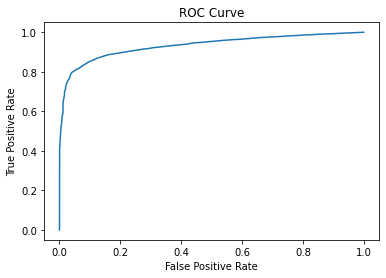

Training set areaUnderROC: 0.9322921328681154


In [200]:
trainingSummary = lrModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

In [388]:

predictions = lrModel.transform(test)

evaluatorLR = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol = 'churn')
area_under_curveLR = evaluatorLR.evaluate(predictions,  {evaluator.metricName: "areaUnderROC"})

print("Area Under Curve = %g" % area_under_curveLR)


Area Under Curve = 0.872132


In [333]:
predictions.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|churn|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(63,[0,1,2,3,4,5,...|  1.0|[-4.1632687920810...|[0.01531832198536...|       1.0|
|(63,[0,1,2,3,4,5,...|  1.0|[-6.1664656783318...|[0.00209424511095...|       1.0|
|(63,[0,1,2,3,4,5,...|  1.0|[-7.7312774017129...|[4.38690594913013...|       1.0|
|(63,[0,1,2,3,4,5,...|  0.0|[-7.7582542329743...|[4.2701930137476E...|       1.0|
|(63,[0,1,2,3,4,5,...|  1.0|[-7.6130380339591...|[4.93724997562589...|       1.0|
|(63,[0,1,2,3,4,6,...|  1.0|[-8.0915274304783...|[3.06028138164769...|       1.0|
|(63,[0,1,2,3,6,9,...|  1.0|[-7.9588721472521...|[3.49424992412447...|       1.0|
|(63,[0,1,3,4,5,6,...|  0.0|[1.91114443319212...|[0.87114766437961...|       0.0|
|(63,[0,1,3,4,5,6,...|  0.0|[1.17255296831496...|[0.76360616669841...|       0.0|
|(63,[0,1,3,4,5,

In [383]:
resultsLR = predictions.select(['prediction', 'churn'])

count = predictions.count()
correct = resultsLR.filter(resultsLR.prediction == resultsLR.churn).count()
wrong = resultsLR.filter(resultsLR.prediction != resultsLR.churn).count()
tp = resultsLR.filter(resultsLR.prediction ==1.0).filter(resultsLR.prediction == resultsLR.churn).count()
fp = resultsLR.filter(resultsLR.prediction ==1.0).filter(resultsLR.prediction != resultsLR.churn).count()
fn = resultsLR.filter(resultsLR.prediction ==0.0).filter(resultsLR.prediction != resultsLR.churn).count()
tn = resultsLR.filter(resultsLR.prediction ==0.0).filter(resultsLR.prediction == resultsLR.churn).count()


accuracyLR = ((tp+tn)/count)*100
precisionLR = (tp/(tp+fp))*100
recallLR = (tp/(tp+fn))*100
print("Correct:{}\nWrong:{}\ntp:{}\nfp:{}\nfn:{}\ntn:{}\nAccuracy: {}\nPrecision: {}\nRecall: {}".format(correct, wrong, tp, fp, fn, tn, accuracyLR, precisionLR, recallLR))


Correct:7320
Wrong:1071
tp:3452
fp:349
fn:722
tn:3868
Accuracy: 87.23632463353593
Precision: 90.8182057353328
Recall: 82.7024436990896


In [387]:
resultsLR = pd.DataFrame([['Logistic Regression', 
accuracyLR, precisionLR, recallLR, area_under_curveLR ]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall','areaUnderROC' ])

resultsLR = resultsLR.sort_values(["Precision", 
"Recall", "a
                                   reaUnderROC"], ascending = False)
print (resultsLR)

                 Model   Accuracy  Precision     Recall  areaUnderROC
0  Logistic Regression  87.236325  90.818206  82.702444      0.872132


In [289]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paraGrid = (ParamGridBuilder()
            .addGrid(lr.regParam, [0.01, 0.5, 2.0])
            .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
            .addGrid(lr.maxIter, [5, 10, 20])
            .build())



In [290]:
cv = CrossValidator(estimator=lr, estimatorParamMaps=paraGrid, evaluator=evaluatorLR, numFolds=5)
cvModel = cv.fit(train)

In [291]:
predictions = cvModel.bestModel.transform(test)

In [292]:
resultsModel = predictions.select(['prediction', 'churn'])

count = predictions.count()
correct = resultsModel.filter(resultsModel.prediction == resultsModel.churn).count()
wrong = resultsModel.filter(resultsModel.prediction != resultsModel.churn).count()
tp = resultsModel.filter(resultsModel.prediction ==1.0).filter(resultsModel.prediction == resultsModel.churn).count()
fp = resultsModel.filter(resultsModel.prediction ==1.0).filter(resultsModel.prediction != resultsModel.churn).count()
fn = resultsModel.filter(resultsModel.prediction ==0.0).filter(resultsModel.prediction != resultsModel.churn).count()
tn = resultsModel.filter(resultsModel.prediction ==0.0).filter(resultsModel.prediction == resultsModel.churn).count()


accuracy = ((tp+tn)/count)*100
precision = (tp/(tp+fp))*100
recall = (tp/(tp+fn))*100
areaUnderROC = metrics.areaUnderROC
print("Correct:{}\nWrong:{}\ntp:{}\nfp:{}\nfn:{}\ntn:{}\nAccuracy: {}\nPrecision: {}\nRecall: {}\nareaUnderROC: {}".format(correct, wrong, tp, fp, fn, tn, accuracy, precision, recall, areaUnderROC))


Correct:7333
Wrong:1058
tp:3479
fp:363
fn:695
tn:3854
Accuracy: 87.39125253247528
Precision: 90.55179593961479
Recall: 83.34930522280786
areaUnderROC: 0.9224277484101303


### Random Forest

In [343]:
from pyspark.ml.classification import RandomForestClassifier
 
rf = RandomForestClassifier(labelCol="churn", featuresCol="features").setImpurity("gini").setMaxDepth(6).setNumTrees(50).setFeatureSubsetStrategy("auto").setSeed(4500)
 
rfModel = rf.fit(train)

In [389]:
predictions = rfModel.transform(test)
evaluatorRF = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol = 'churn')
area_under_curveRF = evaluatorRF.evaluate(predictions,  {evaluator.metricName: "areaUnderROC"})

print("areUnderCurve = %g" % area_under_curveRF)


areUnderCurve = 0.904485


In [390]:
resultsRF = predictions.select(['prediction', 'churn'])

count = predictions.count()
correct = resultsRF.filter(resultsRF.prediction == resultsRF.churn).count()
wrong = resultsRF.filter(resultsRF.prediction != resultsRF.churn).count()
tp = resultsRF.filter(resultsRF.prediction ==1.0).filter(resultsRF.prediction == resultsRF.churn).count()
fp = resultsRF.filter(resultsRF.prediction ==1.0).filter(resultsRF.prediction != resultsRF.churn).count()
fn = resultsRF.filter(resultsRF.prediction ==0.0).filter(resultsRF.prediction != resultsRF.churn).count()
tn = resultsRF.filter(resultsRF.prediction ==0.0).filter(resultsRF.prediction == resultsRF.churn).count()


accuracyRF = ((tp+tn)/count)*100
precisionRF = (tp/(tp+fp))*100
recallRF = (tp/(tp+fn))*100
print("Correct:{}\nWrong:{}\ntp:{}\nfp:{}\nfn:{}\ntn:{}\nAccuracy: {}\nPrecision: {}\nRecall: {}".format(correct, wrong, tp, fp, fn, tn, accuracyRF, precisionRF, recallRF))


Correct:7591
Wrong:800
tp:3633
fp:259
fn:541
tn:3958
Accuracy: 90.46597544988678
Precision: 93.34532374100719
Recall: 87.03881169142309


In [391]:
resultsRF = pd.DataFrame([['Random Forest', 
accuracyRF, precisionRF, recallRF, area_under_curveRF]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall','areaUnderROC'])


resultsRF = resultsRF.sort_values(["Precision", 
"Recall", "areaUnderROC"], ascending = False)
print (resultsRF)

           Model   Accuracy  Precision     Recall  areaUnderROC
0  Random Forest  90.465975  93.345324  87.038812      0.904485


# Gradient-Boosted Trees (GBTs)

In [347]:
from pyspark.ml.classification import GBTClassifier
gbt = GBTClassifier(labelCol="churn", featuresCol="features", maxIter=20)

In [348]:
gbtModel =gbt.fit(train)


In [392]:
predictions = gbtModel.transform(test)
evaluatorGBT = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol = 'churn')
area_under_curveGBT = evaluatorGBT.evaluate(predictions,  {evaluator.metricName: "areaUnderROC"})

print("areUnderCurve = %g" % area_under_curveGBT)


areUnderCurve = 0.922428


In [393]:
resultsGBT = predictions.select(['prediction', 'churn'])

count = predictions.count()
correct = resultsGBT.filter(resultsGBT.prediction == resultsGBT.churn).count()
wrong = resultsGBT.filter(resultsGBT.prediction != resultsGBT.churn).count()
tp = resultsGBT.filter(resultsGBT.prediction ==1.0).filter(resultsGBT.prediction == resultsGBT.churn).count()
fp = resultsGBT.filter(resultsGBT.prediction ==1.0).filter(resultsGBT.prediction != resultsGBT.churn).count()
fn = resultsGBT.filter(resultsGBT.prediction ==0.0).filter(resultsGBT.prediction != resultsGBT.churn).count()
tn = resultsGBT.filter(resultsGBT.prediction ==0.0).filter(resultsGBT.prediction == resultsGBT.churn).count()


accuracyGBT = ((tp+tn)/count)*100
precisionGBT = (tp/(tp+fp))*100
recallGBT = (tp/(tp+fn))*100
print("Correct:{}\nWrong:{}\ntp:{}\nfp:{}\nfn:{}\ntn:{}\nAccuracy: {}\nPrecision: {}\nRecall: {}".format(correct, wrong, tp, fp, fn, tn, accuracyGBT, precisionGBT, recallGBT))


Correct:7741
Wrong:650
tp:3762
fp:238
fn:412
tn:3979
Accuracy: 92.25360505303301
Precision: 94.05
Recall: 90.12937230474365


In [394]:
resultsGBT = pd.DataFrame([['Gradient-Boosted Trees', 
accuracyGBT, precisionGBT, recallGBT, area_under_curveGBT]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall','areaUnderROC'])

resultsGBT = resultsGBT.sort_values(["Precision", 
"Recall", "areaUnderROC"], ascending = False)
print (resultsGBT)

                    Model   Accuracy  Precision     Recall  areaUnderROC
0  Gradient-Boosted Trees  92.253605      94.05  90.129372      0.922428


### Decision Tree

In [352]:
from pyspark.ml.classification import DecisionTreeClassifier
dt = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'churn', maxDepth = 3)
dtModel = dt.fit(train)


In [395]:
predictions = dtModel.transform(test)
evaluatorDT = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol = 'churn')
area_under_curveDT = evaluatorDT.evaluate(predictions,  {evaluator.metricName: "areaUnderROC"})

print("areUnderCurve = %g" % area_under_curveDT)


areUnderCurve = 0.90857


In [396]:
resultsDT = predictions.select(['prediction', 'churn'])

count = predictions.count()
correct = resultsDT.filter(resultsDT.prediction == resultsDT.churn).count()
wrong = resultsDT.filter(resultsDT.prediction != resultsDT.churn).count()
tp = resultsDT.filter(resultsDT.prediction ==1.0).filter(resultsDT.prediction == resultsDT.churn).count()
fp = resultsDT.filter(resultsDT.prediction ==1.0).filter(resultsDT.prediction != resultsDT.churn).count()
fn = resultsDT.filter(resultsDT.prediction ==0.0).filter(resultsDT.prediction != resultsDT.churn).count()
tn = resultsDT.filter(resultsDT.prediction ==0.0).filter(resultsDT.prediction == resultsDT.churn).count()


accuracyDT = ((tp+tn)/count)*100
precisionDT = (tp/(tp+fp))*100
recallDT = (tp/(tp+fn))*100
print("Correct:{}\nWrong:{}\ntp:{}\nfp:{}\nfn:{}\ntn:{}\nAccuracy: {}\nPrecision: {}\nRecall: {}".format(correct, wrong, tp, fp, fn, tn, accuracyDT, precisionDT, recallDT))


Correct:7625
Wrong:766
tp:3677
fp:269
fn:497
tn:3948
Accuracy: 90.8711714932666
Precision: 93.18297009630005
Recall: 88.09295639674174


In [397]:
resultsDT = pd.DataFrame([['Decision Tree', 
accuracyDT, precisionDT, recallDT, area_under_curveDT]], columns = ['Model', 
'Accuracy', 'Precision', 'Recall','areaUnderROC'])


resultsDT = resultsDT.sort_values(["Precision", 
"Recall", "areaUnderROC"], ascending = False)
print (resultsDT)

           Model   Accuracy  Precision     Recall  areaUnderROC
0  Decision Tree  90.871171   93.18297  88.092956       0.90857


In [398]:
models_evaluation =pd.concat([resultsLR, resultsRF, resultsGBT, resultsDT], ignore_index=True)
models_evaluation = models_evaluation.sort_values(["Precision", "Recall", "areaUnderROC"], ascending = False)
models_evaluation

,Model,Accuracy,Precision,Recall,areaUnderROC
2,Gradient-Boosted Trees,92.253605,94.050000,90.129372,0.922428
1,Random Forest,90.465975,93.345324,87.038812,0.904485
3,Decision Tree,90.871171,93.182970,88.092956,0.908570
0,Logistic Regression,87.236325,90.818206,82.702444,0.872132


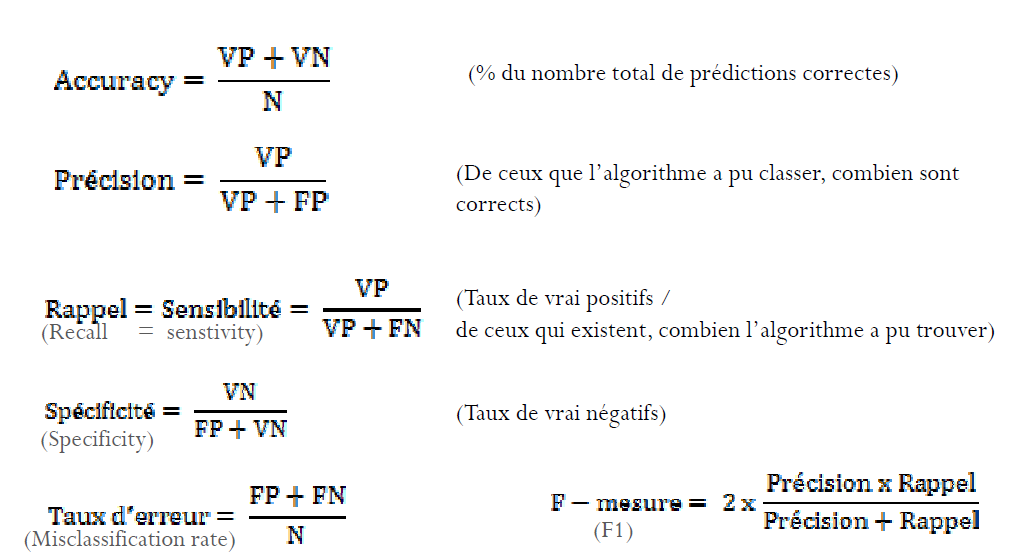

In [399]:
from IPython.display import Image
Image(filename='metrics.png') 

In [ ]:
#D'aprés les résultats obtenus, le modèle Gradient Bossted Trees est le plus précis pour notre problème de classification
# par rapport aux autres modèles que nous avons essayé.

# Save The Model

In [411]:
modelPath = '/work/'
gbtModel.write().overwrite().save("gbt")


# Loading Saved Model

In [414]:
from pyspark.ml.classification import GBTClassificationModel

savedModel = GBTClassificationModel.load('gbt')


# Consumer

In [147]:
from kafka import KafkaConsumer
import json


c = KafkaConsumer('test', bootstrap_servers=['kafka:9093'], api_version=(2,6,0))

def process_msg(msg):
    print(msg.offset)
    print(json.loads(msg.value))

data_stream = []

for msg in c:
    process_msg(msg)
    data_stream.append(msg.value)
    
    
    


2147
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

2148
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

2149
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

2150
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

2151
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

2152
[{'month': 6, 'user_lifetime': 3, 'user_intake': 1, 'user_no_outgoing_activity_in_days': 1, 'user_account_balance_last': 23.79, 'user_spendings': 0.21, 'user_has_outgoing_calls': 1, 'user_has_outgoing_sms': 1, 'user_use_gprs': 0, 'user_does_reload': 1, 'reloads_inactive_days': 3, 'reloads_count': 1, 'reloads_sum': 24.02, 'calls_outgoing_count': 3, 'calls_outgoing_spendings': 0.0, 'calls_outgoing_duration': 1.18, 'calls_outgoing_spendings_max': 0.0, 'calls_outgoing_duration_max': 1.18, 'calls_outgoing_inactive_days': 1, 'calls_outgoing_to_onnet_count': 0, 'calls_outgoing_to_onnet_spendings': 0, 'calls_outgoing_to_onnet_duration': 0, 'calls_outgoing_to_onnet_inactive_days': 1, 'calls_outgoing_to_offnet_count': 0, 'calls_outgoing_to_offnet_spendings': 0.0, 'calls_outgoing_to_offnet_duration': 0.0, 'calls_outgoing_to_offnet_inactive_days': 1, 'calls_outgoing_to_abroad_count': 0, 'calls_outgoing_to_abroad_spendings': 0, 'calls_outgoing_to_abroad_duration': 0, 'calls_outgoing_to_abroad_

KeyboardInterrupt: 

In [148]:
import json

schema=["month","user_lifetime","user_intake","user_no_outgoing_activity_in_days","user_account_balance_last",
       "user_spendings","user_has_outgoing_calls","user_has_outgoing_sms","user_use_gprs",
       "user_does_reload","reloads_inactive_days","reloads_count","reloads_sum","calls_outgoing_count",
       "calls_outgoing_spendings","calls_outgoing_duration","calls_outgoing_spendings_max","calls_outgoing_duration_max",
       "calls_outgoing_inactive_days","calls_outgoing_to_onnet_count","calls_outgoing_to_onnet_spendings",
       "calls_outgoing_to_onnet_duration","calls_outgoing_to_onnet_inactive_days","calls_outgoing_to_offnet_count",
       "calls_outgoing_to_offnet_spendings","calls_outgoing_to_offnet_duration","calls_outgoing_to_offnet_inactive_days",
       "calls_outgoing_to_abroad_count","calls_outgoing_to_abroad_spendings",
       "calls_outgoing_to_abroad_duration","calls_outgoing_to_abroad_inactive_days","sms_outgoing_count",
       "sms_outgoing_spendings","sms_outgoing_spendings_max	sms_outgoing_inactive_days",
       "sms_outgoing_to_onnet_count","sms_outgoing_to_onnet_spendings",
       "sms_outgoing_to_onnet_inactive_days","sms_outgoing_to_offnet_count",
       "sms_outgoing_to_offnet_spendings","sms_outgoing_to_offnet_inactive_days","sms_outgoing_to_abroad_count",
       "sms_outgoing_to_abroad_spendings","sms_outgoing_to_abroad_inactive_days","sms_incoming_count","sms_incoming_spendings",
       "sms_incoming_from_abroad_count","sms_incoming_from_abroad_spendings","gprs_session_count","gprs_usage",
       "gprs_spendings","gprs_inactive_days","last_100_reloads_count","last_100_reloads_sum","last_100_calls_outgoing_duration",
       "last_100_calls_outgoing_to_onnet_duration","last_100_calls_outgoing_to_offnet_duration",
       "last_100_calls_outgoing_to_abroad_duration","last_100_sms_outgoing_count","last_100_sms_outgoing_to_onnet_count",
       "last_100_sms_outgoing_to_offnet_count","last_100_sms_outgoing_to_abroad_count","last_100_gprs_usage","churn"]


df_stream = spark.createDataFrame(m,schema=schema).show()




+-----+-------------+-----------+---------------------------------+-------------------------+--------------+-----------------------+---------------------+-------------+----------------+---------------------+-------------+-----------+--------------------+------------------------+-----------------------+----------------------------+---------------------------+----------------------------+-----------------------------+---------------------------------+--------------------------------+-------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------------------+----------------------------------+---------------------------------+--------------------------------------+------------------+----------------------+-----------------------------------------------------+---------------------------+-------------------------------+-----------------------------------+------